# TODO:
- [ ] refactor frame creation
- [ ] save labels and label map in vid folder
- [ ] alert if vid with same name already exists
- [ ]  fix logging

# Setup

## imports

In [1]:
import os
import sys
import time
import json
from shutil import copy
from sklearn.utils import shuffle

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D, MaxPooling2D)
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [3]:
import cv2

In [4]:
from contextlib import redirect_stdout

In [5]:
# setup matplotlib to display plots in the notebook
%matplotlib inline

# third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setup display options
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 400
pd.options.display.float_format = '{:,.5g}'.format
np.set_printoptions(precision=5, suppress=False)

# setup seaborn to use matplotlib defaults & styles
sns.set()
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})

## paths

In [6]:
pwd = os.getcwd().replace("notebooks","")
pwd

'/mnt/seals/'

In [7]:
path_cache = pwd + 'cache/'
path_models = pwd + 'models/'

In [8]:
# for constructing vids in cache REFACTOR
path_data = pwd + 'data/images/'

In [9]:
# folder where we'll store each vid grouped into folders
path_vids = path_cache + 'vids/'

## setup logging

In [10]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(pwd, "logs")),
        logging.StreamHandler()
    ])

logger = logging.getLogger()

# helper functions

In [11]:
def plot_pic(imgpath):
    plt.imshow(plt.imread(imgpath))
    plt.show()

# Convert data back into sequence for video classification

## read list of paths across train/val/test and seal / no seal folders

In [11]:
path_data

'/mnt/seals/data/images/'

In [83]:
paths_jpgs = []
for folder, subs, files in os.walk(path_data):        
    for filename in files:
        if filename[-4:] == '.jpg' or  filename[-4:] == 'jpeg':
            paths_jpgs.append(os.path.abspath(os.path.join(folder, filename)))

In [84]:
# create dataframe from paths
dfp = pd.DataFrame(paths_jpgs)
dfp.columns = ['path']
dfp['label'] = dfp['path'].str.split("/").str.get(-2)
dfp['filename'] = dfp['path'].str.split("/").str.get(-1)
dfp.sort_values("filename", inplace=True)
dfp.reset_index(inplace=True,drop=True)
dfp['vid'] = dfp['filename'].str.split("-").str.get(0) + '-' + dfp['filename'].str.split("-").str.get(1)
dfp['seal'] = pd.get_dummies(dfp['label'])['seal']
dfp.to_csv(path_vids + "df.csv")

In [85]:
vids = list(dfp['vid'].unique())

In [15]:
dfp.head(20)

,path,label,filename,vid,seal
0,/mnt/seals/data/images/train/noseal/s1-218-00001.jpeg,noseal,s1-218-00001.jpeg,s1-218,0
1,/mnt/seals/data/images/train/noseal/s1-218-00002.jpeg,noseal,s1-218-00002.jpeg,s1-218,0
2,/mnt/seals/data/images/train/noseal/s1-218-00003.jpeg,noseal,s1-218-00003.jpeg,s1-218,0
3,/mnt/seals/data/images/train/noseal/s1-218-00004.jpeg,noseal,s1-218-00004.jpeg,s1-218,0
4,/mnt/seals/data/images/train/noseal/s1-218-00005.jpeg,noseal,s1-218-00005.jpeg,s1-218,0
5,/mnt/seals/data/images/train/noseal/s1-218-00006.jpeg,noseal,s1-218-00006.jpeg,s1-218,0
6,/mnt/seals/data/images/train/noseal/s1-218-00007.jpeg,noseal,s1-218-00007.jpeg,s1-218,0
7,/mnt/seals/data/images/train/noseal/s1-218-00008.jpeg,noseal,s1-218-00008.jpeg,s1-218,0
8,/mnt/seals/data/images/train/noseal/s1-218-00009.jpeg,noseal,s1-218-00009.jpeg,s1-218,0
9,/mnt/seals/data/images/train/noseal/s1-218-00010.jpeg,noseal,s1-218-00010.jpeg,s1-218,0


In [16]:
dfp['vid'].value_counts().sort_index()

s1-218       138
s10-6558     184
s11-7363     303
s12-3465     644
s13-14       156
s14-1705     129
s15-2589     147
s16-0        129
s17-2973     294
s18-630      350
s19-672      166
s2-1133      156
s20-842      331
s21-919      147
s22-3733     129
s23-4847     156
s24-5851     138
s25-5886     193
s26-8164     266
s27-8212     174
s28-20       285
s29-316      405
s3-1993      184
s30-516      156
s31-784      193
s32-3110    1407
s33-3405     313
s34-3590     266
s35-3664     147
s36-3838     230
s37-3930     119
s38-4060     303
s39-4336     239
s4-6975      129
s40-4508     377
s41-4712     368
s42-4950     221
s43-5211     221
s44-5304     129
s45-6301     147
s46-8087     166
s5-1102      303
s6-1247      589
s7-2029      395
s8-2244      634
s9-5491      202
Name: vid, dtype: int64

## examine seal / no seal across vids

In [ ]:
pd.DataFrame(dfp.groupby(['vid','label']).agg(len)['filename'])

## [REFACTOR] move images into vid folders and create targets.npy and label_map in vid folder

In [ ]:
path_vids

In [ ]:
# create folder for vid in cache
for i, folder in enumerate(vids):
    print(i, folder)
    os.makedirs(path_vids + folder)

In [ ]:
# copy vid frames to folder for vid
# REFACTOR: extract from vid

for i, row in enumerate(dfp.values):
    
    path = row[0]
    filename = row[2]
    folder = row[3]
    
    # create folder for frames for this vid
    if not os.path.exists(path_vids + folder + '/frames/'):
        os.makedirs(path_vids + folder + '/frames/')
    
    copy(path, path_vids + folder + '/frames/' + filename)
    
    if i % 1000 == 0:
        print(i,len(dfp))

In [ ]:
dfp.head(100)

> REFACTOR TARGETS BEING INPUT AS CSV WITH VIDEO

> nb must be sorted in sequence

In [ ]:
for i, vid in enumerate(vids):
    
    print("Begin extracting features for vid {}/{}: {}".format((i+1),len(vids),vid))

    # path to this vid
    path_vid = path_vids + vid +'/'

    # get list of seal labels for this vid
    targets = list(dfp[dfp['vid'] == vid]['seal'])

    # convert to arrays
    targets = np.array(targets)

    np.save(path_vid + 'targets', targets)

# Precompute features using pretrained models

> https://keras.io/applications/

In [17]:
def load_pretrained_model(pretrained_model_name = "Xception", pooling = "max"):
    """ Load pretrained model with given pooling applied
    
    Args:
        vid: name of vid (should already have frames in folder in /cache/vids/*vid_name*/frames/)
        pretrained_model: name of pretrained model ["Xception", "VGG16", "ResNet50", "InceptionV3", "InceptionResNetV2", "MobileNetV2"]
        pooling: pooling strategy for final pretrained model layer ["max","avg"]
    
    Returns:
        Pretrained model object, required image input shape, model image preprocessing function
    """
    
    # initialize output
    model = None
    model_input_shape = (0,0)
    preprocess_input = None
    
    ###########################
    ### import pretrained model
    ###########################
    if pretrained_model_name == "xception":   
        from keras.applications.xception import Xception, preprocess_input
        model = Xception(include_top=False, weights='imagenet', pooling=pooling)
        model_input_shape = (299,299)
    elif pretrained_model_name == "vgg16":   
        from keras.applications.vgg16 import VGG16, preprocess_input
        model = VGG16(include_top=False, weights='imagenet', pooling=pooling)
        model_input_shape = (224,224)
    elif pretrained_model_name == "resnet50":   
        from keras.applications.resnet50 import ResNet50, preprocess_input
        model = ResNet50(include_top=False, weights='imagenet', pooling=pooling)
        model_input_shape = (224,224)
    elif pretrained_model_name == "inception_v3":   
        from keras.applications.inception_v3 import InceptionV3, preprocess_input
        model = InceptionV3(include_top=False, weights='imagenet', pooling=pooling)
        model_input_shape = (299,299)
    elif pretrained_model_name == "inception_resnet_v2":   
        from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
        model = InceptionResNetV2(include_top=False, weights='imagenet', pooling=pooling)
        model_input_shape = (299,299)
    elif pretrained_model_name == "mobilenetv2_1.00_224":   
        from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
        model = MobileNetV2(include_top=False, weights='imagenet', pooling=pooling)
        model_input_shape = (224,224)
    else:
        raise NameError('Invalid pretrained model name - must be one of ["Xception", "VGG16", "ResNet50", "InceptionV3", "InceptionResNetV2", "MobileNetV2"]')
    
    return model, model_input_shape, preprocess_input

In [18]:
def save_pretrained_features_for_frames(vid_name, pretrained_model, model_input_shape, preprocess_input, pooling):
    """ Save pretrained feature vector for frames of vid using given pretrained model and pooling method
    
    Args:
        vid_name: name of vid (should already have frames in folder in `/cache/vids/*vid_name*/frames/`)
        pretrained_model: pretrained model object loaded using `load_pretrained_model`
        model_input_shape: shape of model input (also loaded using `load_pretrained_model`)
        preprocess_input: model preprocessing function (also loaded using `load_pretrained_model`)
        pooling: pooling method used with pretrained model
    
    Returns:
        None. Saves pretrained frames to `/cache/vids/*vid_name*/features/*pretrained_model_name*_*pooling*pooling.npy`
    """
    
    # setup path to save featuers
    path_features = path_vids + vid_name + '/features/'
    if not os.path.exists(path_features):
        os.makedirs(path_features)
    path_output = path_features + 'features_' + pretrained_model.name + '_' + pooling + 'pooling'
    
    try:
        if not os.path.exists(path_output + '.npy'):

            path_frames = path_vids + vid_name +'/frames/'

            # initialize features list
            features = []

            frame_paths = os.listdir(path_frames)
            
            # sort paths in sequence (they were created with incrementing filenames through time)
            frame_paths.sort()

            # load each frame in vid and get features
            for j, frame_path in enumerate(frame_paths):

                # load image & preprocess
                image = cv2.imread(path_frames + frame_path, cv2.COLOR_BGR2RGB)
                img = cv2.resize(image, model_input_shape, interpolation=cv2.INTER_AREA)
                img = img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)

                # get features from pretrained model
                feature = pretrained_model.predict(img).ravel()
                features.append(feature)

            # convert to arrays
            features = np.array(features)

            logger.info("Features saved: {}".format(path_output))
            np.save(path_output, features)
        else:
            logger.info("Features already cached: {}".format(path_output))
            
    except Exception as e:
        logging.fatal(e, exc_info=True)
    
    return True

## save image features for each frame in each vid to numpy array for a set of pretrained models and pooling strategies

In [69]:
# save pretrained features for each vid using each pretrained model
# pretrained_model_names = ["Xception", "VGG16", "ResNet50", "InceptionV3", "InceptionResNetV2", "MobileNetV2"]
pretrained_model_names = ["inception_resnet_v2", "inception_v3", "mobilenetv2_1.00_224", "resnet50", "vgg16", "xception"]
poolings = ['avg','max']
sequence_lengths = [1, 3, 5, 10, 15, 20, 40]

In [ ]:
log_step = 0

# for each pretrained model & pooling combination
for pretrained_model_name in pretrained_model_names:
    for pooling in poolings:
        
        # load pretrained model, required shape for model and its preprocessing function
        pretrained_model, model_input_shape, preprocess_input = load_pretrained_model(pretrained_model_name, pooling)
        
        # save features for each vid using this pretrained model & pooling combination
        for vid_name in vids:
            
            # logging step in overall feature construction process
            log_step+=1
            logging.info("Caching features: step {}/{}".format(log_step, len(pretrained_models) * len(poolings) * len(vids)))
            
            # save features for this vid
            save_pretrained_features_for_frames(vid_name, pretrained_model, model_input_shape, preprocess_input, pooling)

## Generate sequence features for video 

In [20]:
def save_pretrained_features_for_sequence(vid_name, pretrained_model_name, pooling, sequence_length):
    """
    Load precomputed features for vid and save them into sequences with given sequence length,
    skipping the first (sequence_length-1) frames
    
    Args:
        vid_name: name of vid (should already have frames in folder in `/cache/vids/*vid_name*/frames/`)
        pretrained_model_name: name of pretrained model whose features should be loaded (assuming these were already precomputed)
        pooling: pooling method used with pretrained model
        sequence_length: length of sequence to construct
    
    Returns:
        None. Saves sequence of pretrained model features with targets to: 
        `/cache/vids/*vid_name*/sequences/features_sequence_*sequence_length*_*pretrained_model_name*_*pooling*pooling.npy`
    
    """

    try:
        # path to load features from
        path_features = path_vids + vid_name + '/features/features_' + pretrained_model_name + '_' + pooling + 'pooling.npy'
        
        # setup path to save sequence features
        path_sequences = path_vids + vid_name + '/sequences/'
        if not os.path.exists(path_sequences):
            os.makedirs(path_sequences)
        #
        path_output = path_sequences + 'features_sequence_' + str(sequence_length) + '_' + pretrained_model_name + '_' + pooling + 'pooling'

        if not os.path.exists(path_output + '.npy'):

            # temp lists to store sequences
            x = []

            # load precomputed features
            features = np.load(path_features)

            for i in range(sequence_length, len(features) + 1):
                x.append(features[i-sequence_length:i])

            output = np.array(x)
            
            np.save(path_output, output)
            logger.info("Sequence features saved: {}".format(path_output))
#             return output
            return True
        else:
            logger.info("Sequences features already cached: {}".format(path_output))
#             return np.load(path_output + '.npy')
            return True
            
    except Exception as e:
        logging.fatal(e, exc_info=True)
        return False

In [21]:
def save_targets_for_sequence(vid_name, sequence_length):
    """
    Load targets for vid and save them into sequences with given sequence length,
    skipping the first (sequence_length-1) frames
    
    Args:
        vid_name: name of vid (should already have frames in folder in `/cache/vids/*vid_name*/frames/`)
        sequence_length: length of sequence to construct
    
    Returns:
        None. Saves sequence of targets for vid given sequence length to: 
        `/cache/vids/*vid_name*/sequences/targets_*sequence_length*.npy`
    
    """
    try:
        # setup path to save sequence targets
        path_sequences = path_vids + vid_name + '/sequences/'
        if not os.path.exists(path_sequences):
            os.makedirs(path_sequences)
        #
        path_output = path_sequences + 'targets_sequence_' + str(sequence_length)

        if not os.path.exists(path_output + '.npy'):

            # temp lists to store sequences
            y = []

            # load precomputed features
            targets = np.load(path_vids + vid_name + '/targets.npy')

            for i in range(sequence_length, len(targets) + 1):
                y.append(targets[i-1])
                
            output = to_categorical(np.array(y))

            np.save(path_output, output)
            logger.info("Sequences targets saved: {}".format(path_output))
            return True
#             return output
        else:
            logger.info("Loading cached sequences: {}".format(path_output))
#             return np.load(path_output + '.npy')
            return True
            
    except Exception as e:
        logging.fatal(e, exc_info=True)
        return False

## generate features and sequences for all vids with all sequence length, pretrained models and pooling combinations

In [95]:
# ### Delete broken sequence files

# for vid_name in vids:
#     # build dataframe with paths and sizes for sequence outputs for this vid (excl targets)
#     # will recompute if size less than 400k
#     paths_seq = [path_vids + vid_name + '/sequences/' + p for p in os.listdir(path_vids + vid_name + '/sequences/')]
#     sizes = [os.path.getsize(p) for p in paths_seq]
#     dfs = pd.DataFrame({"path": paths_seq,"size":sizes})
#     dfs['filename'] = dfs['path'].str.split("/").str.get(-1)
#     dfs['skip'] = dfs['filename'].str.contains("targets").astype(int)
#     dfs = dfs[dfs['skip'] == 0]
#     dfs = dfs[dfs['size'] < 400000]

#     # delete broken sequence files
#     for row in dfs.values:
#         # get sequence length and model name from filename
#         rd = dict(zip(dfs.columns, row))
#         print(rd['path'])
#         os.remove(rd['path'])

In [108]:
log_step = 0

for vid_name in vids:

    # generate target and features sequences for each vid for each feature combination and sequence length
    for sequence_length in sequence_lengths:

        # generate targets for this sequence length
        save_targets_for_sequence(vid_name, sequence_length)

        for pretrained_model_name in pretrained_model_names:
            for pooling in poolings:

                # logging step in overall feature construction process
                log_step+=1
                logging.info("Caching sequences: step {}/{}".format(log_step, len(pretrained_model_names) * len(poolings) * len(vids) * len(sequence_lengths)))

                # generate features sequence for this sequence length
                save_pretrained_features_for_sequence(vid_name, pretrained_model_name, pooling, sequence_length)

In [ ]:
logging.info("Done precomputing features and sequences")

# Create train/test split

## functions to load precomputed sequence data for list of vids

In [80]:
def get_sequence_data_for_vids(list_of_vid_names, sequence_length, pretrained_model_name, pooling):
    """
    Load precomputed sequence features data of given length together with targets [returns data later to train/eval models: x, y]
    for list of vid names and concatenate into one long array
    
    Args:
        list_of_vid_names: name of vid (should already have frames in folder in `/cache/vids/*vid_name*/frames/`)
        sequence_length: length of sequence to fetch precomputed features for
        pretrained_model_name: name of pretrained model whose features should be loaded (assuming these were already precomputed)
        pooling: pooling method used with pretrained model
    
    Returns:
        sequence_features_array_for_all_vids, sequence_targets_array_for_all_vids
    
    """
    
    # create clips of length NUM_FRAMES
    x = []
    y = []
    
    for v, vid_name in enumerate(list_of_vid_names):
        
        path_sequences_features = path_vids + vid_name + '/sequences/features_sequence_' + str(sequence_length) + '_' + pretrained_model_name + '_' + pooling + 'pooling.npy'
        path_sequences_targets = path_vids + vid_name + '/sequences/targets_sequence_' + str(sequence_length) + '.npy'

        # load precomputed features
        features = np.load(path_sequences_features)
        targets = np.load(path_sequences_targets)
        
        x.extend(features)
        y.extend(targets)

    return np.array(x), np.array(y)

## generate train / test split

> todo: write functions to make this quicker

> todo: cross-validation

> todo: experiments with config files and json results with function to aggregate to dataframe

In [86]:
vids_train = vids[0:40]
vids_valid = vids[40:45]
vids_test = vids[45:]
# vids_train = vids[0:5]
# vids_valid = vids[40:42]
# vids_test = vids[40:]

# Fit models

In [ ]:
def fit_model(model_id, architecture, layer_1_sizefactor, layer_2_sizefactor, layer_3_sizefactor, dropout, sequence_length, pretrained_model_name, pooling):

    ###########################
    ### create folder for model 
    ###########################

    path_model = path_models + str(model_id) + '/'
    if not os.path.exists(path_model):
        os.makedirs(path_model)

    ###########################
    ### create train/test split
    ###########################

    # load sequence data with given sequence length, pretrained model and pooling method
    x_train, y_train = get_sequence_data_for_vids(vids_train, sequence_length, pretrained_model_name, pooling)
    x_valid, y_valid = get_sequence_data_for_vids(vids_valid, sequence_length, pretrained_model_name, pooling)
    x_test, y_test = get_sequence_data_for_vids(vids_test, sequence_length, pretrained_model_name, pooling)

    NUM_CLASSES = y_train.shape[1]
    NUM_FEATURES = x_train.shape[2]
    SEQ_LENGTH = x_train.shape[1]
    
#     # reshape sequence length 1 into image features if not a sequence
#     if sequence_length == 1:
#         x_train = np.squeeze(x_train, axis=1)
#         x_valid = np.squeeze(x_valid, axis=1)
#         x_test = np.squeeze(x_test, axis=1)

    # shuffle test and train batches
    x_train, y_train = shuffle(x_train, y_train)
    x_valid, y_valid = shuffle(x_valid, y_valid)

    ##############################
    ### keep track of model params
    ##############################

    # create dict with model parameters
    model_params = {}

    model_params['id'] = str(model_id)

    NUM_EPOCHS = 50
    BATCH_SIZE = 32
    model_params['NUM_EPOCHS'] = NUM_EPOCHS
    model_params['BATCH_SIZE'] = BATCH_SIZE
    
    model_params['NUM_CLASSES'] = NUM_CLASSES
    model_params['NUM_FEATURES'] = NUM_FEATURES
    model_params['SEQ_LENGTH'] = SEQ_LENGTH
    
    model_params['pretrained_model_name'] = pretrained_model_name
    model_params['pretrained_model_pooling'] = pooling

    model_params['shape_x_test'] = str(x_train.shape)
    model_params['shape_y_train'] = str(y_train.shape)
    model_params['shape_x_test'] = str(x_test.shape)

    model_params['model_architecture'] = architecture
    model_params['model_layer_1_sizefactor'] = layer_1_sizefactor
    model_params['model_layer_2_sizefactor'] = layer_2_sizefactor
    model_params['model_layer_3_sizefactor'] = layer_3_sizefactor
    model_params['model_dropout'] = dropout

    ################
    ### define model
    ################

    if architecture == "LSTM":
        # https://github.com/sagarvegad/Video-Classification-CNN-and-LSTM-/blob/master/train_CNN_RNN.py
        model = Sequential()

        # layer 1 (LSTM layer)
        model.add(LSTM(NUM_FEATURES//layer_1_sizefactor, return_sequences=False, dropout=dropout, input_shape=(SEQ_LENGTH, NUM_FEATURES)))

        # layer 2 (dense)
        if layer_2_sizefactor > 0:
            model.add(Dropout(dropout))
            model.add(Dense(NUM_FEATURES//layer_2_sizefactor, activation='relu'))

        # layer 3 (dense)
        if layer_2_sizefactor > 0 and layer_3_sizefactor > 0:
            model.add(Dropout(dropout))
            model.add(Dense(NUM_FEATURES//layer_3_sizefactor, activation='relu'))

        # final layer
        model.add(Dropout(dropout))
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        # define optimizer and compile model
        opt = Adam()
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    if architecture == 'MLP':
        model = Sequential()
        model.add(Flatten(input_shape=(SEQ_LENGTH, NUM_FEATURES)))
        model.add(Dense(NUM_FEATURES//2, activation='relu'))

        if layer_2_sizefactor > 0:
            model.add(Dense(NUM_FEATURES//layer_2_sizefactor, activation='relu'))
            model.add(Dropout(dropout))

        if layer_2_sizefactor > 0 and layer_3_sizefactor > 0:
            model.add(Dense(NUM_FEATURES//layer_3_sizefactor, activation='relu'))
            model.add(Dropout(dropout))

        # final layer
        model.add(Dropout(dropout))
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        # define optimizer and compile model
        opt = Adam()
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # save model summary to file
    with open(path_model + 'model_summary.txt', 'w') as f:
        with redirect_stdout(f):
            model.summary()

    # track number of params in model
    model_params['param_count'] = model.count_params()

    #############
    ### fit model
    #############

    # setup training callbacks
    callback_stopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
    callback_csvlogger = CSVLogger(path_model + 'training.log')
    callback_checkpointer = ModelCheckpoint(path_model +  'model.h5', monitor='val_acc', 
                                 save_best_only=True, verbose=0)

    history = model.fit(x_train, y_train, 
              validation_data=(x_valid,y_valid),
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              callbacks=[callback_stopper, callback_checkpointer, callback_csvlogger],
              shuffle=True,
              verbose=1)

    # get number of epochs actually trained (might have early stopped)
    epochs_trained = callback_stopper.stopped_epoch
    if epochs_trained == 0:
        epochs_trained = NUM_EPOCHS - 1

    model_params['fit_num_epochs'] = epochs_trained
    model_params['fit_val_acc'] = history.history['val_acc'][epochs_trained]
    model_params['fit_train_acc'] = history.history['acc'][epochs_trained]
    model_params['fit_val_loss'] = history.history['val_loss'][epochs_trained]
    model_params['fit_train_loss'] = history.history['loss'][epochs_trained]

    #######################
    ### predict on test set
    #######################

    # calculate predictions on test set
    predictions = model.predict(x_test)

    # calculate test error 
    pdf = pd.DataFrame(predictions)
    pdf.columns = ['noseal','seal']

    # get filenames for predictions
    filenames = []
    for vid_name in vids_test:
        filenames_vid = list(dfp[dfp['vid'] == vid_name]['path'])
        filenames.extend(filenames_vid[sequence_length-1:])
    pdf['filename'] = filenames
    print(len(filenames))
    truth = pd.DataFrame(y_test)
    truth.columns = ['truth_noseal','truth_seal']
    truth = truth[['truth_seal']]
    pdf['prediction'] = pdf['seal'].apply(lambda x: round(x))
    pdf = pd.concat([pdf, truth], axis=1)
    pdf['error'] = (pdf['prediction'] != pdf['truth_seal']).astype(int)

    test_acc = 1 - pdf['error'].mean()

    pdf.to_csv(path_model + 'test_predictions.csv')

    model_params['fit_test_acc'] = 1 - pdf['error'].mean()
    logger.info("model {} test acc: {}".format(model_id, test_acc))

    #############################
    ### save model params to file
    #############################
    with open(path_model + 'params.json', 'w') as f:
        json.dump(model_params, f)

In [88]:
layer_1_sizefactors = [1,2,4,8]
layer_2_sizefactors = [0,1,2,4,8]
layer_3_sizefactors = [0,1,2,4,8]
dropouts = [0, 0.1, 0.2,0.3,0.4,0.5]
architectures = ['LSTM', "MLP"]

In [ ]:
model_id = 0

# pick up where left off with model id
if len(os.listdir(path_models)) > 0:
    model_id = pd.DataFrame(os.listdir(path_models), columns=['model_id'], dtype='int').sort_values('model_id').tail(1).values[0][0] + 1

for pretrained_model_name in pretrained_model_names:
    for pooling in poolings:
        for sequence_length in sequence_lengths:
            for architecture in architectures:
                for layer_1_sizefactor in layer_1_sizefactors:
                    for layer_2_sizefactor in layer_2_sizefactors:
                        for layer_3_sizefactor in layer_3_sizefactors:
                            for dropout in dropouts:
                                
                                # skip LSTM experiement if not a sequence
                                if sequence_length == 1 and architecture == "LSTM":
                                    continue
                                
                                # log experiment
                                param_names = ["model_id", "architecture", "layer_1_sizefactor", "layer_2_sizefactor", "layer_3_sizefactor", "dropout", "sequence_length", "pretrained_model_name", "pooling"]
                                param_values = [str(x) for x in [model_id, architecture, layer_1_sizefactor, layer_2_sizefactor, layer_3_sizefactor, dropout, sequence_length, pretrained_model_name, pooling]]

                                experiment_description = ""
                                for c, p in enumerate(param_names):
                                    experiment_description += p + ':' + param_values[c] + ', '

                                # run experiment
                                logging.info("begin experiment {}".format(experiment_description))
                                fit_model(model_id, architecture, layer_1_sizefactor, layer_2_sizefactor, layer_3_sizefactor, dropout, sequence_length, pretrained_model_name, pooling)
                                
                                model_id+=1

2018-12-13 23:43:31,852 [MainThread  ] [INFO ]  begin experiment model_id:0, architecture:MLP, layer_1_sizefactor:1, layer_2_sizefactor:0, layer_3_sizefactor:0, dropout:0, sequence_length:1, pretrained_model_name:inception_resnet_v2, pooling:avg, 


Train on 10169 samples, validate on 2087 samples
Epoch 1/50
10169/10169 [==============================] - 3s 323us/step - loss: 0.4579 - acc: 0.8086 - val_loss: 0.6004 - val_acc: 0.6833
Epoch 2/50
 4064/10169 [==========>...................] - ETA: 1s - loss: 0.3472 - acc: 0.8610

## hack

In [63]:
#model_id= 148

148

In [77]:
architecture= "LSTM"
layer_1_sizefactor=2
layer_2_sizefactor=4
layer_3_sizefactor=8
dropout = 0.2
pooling = 'max'

In [78]:
sequence_lengths

[1, 3, 5, 10, 15, 20, 40]

In [89]:
for pretrained_model_name in pretrained_model_names:
    for sequence_length in sequence_lengths:
        if sequence_length > 1:

            # log experiment
            param_names = ["model_id", "architecture", "layer_1_sizefactor", "layer_2_sizefactor", "layer_3_sizefactor", "dropout", "sequence_length", "pretrained_model_name", "pooling"]
            param_values = [str(x) for x in [model_id, architecture, layer_1_sizefactor, layer_2_sizefactor, layer_3_sizefactor, dropout, sequence_length, pretrained_model_name, pooling]]

            experiment_description = ""
            for c, p in enumerate(param_names):
                experiment_description += p + ':' + param_values[c] + ', '

            # run experiment
            logging.info("begin experiment {}".format(experiment_description))
            fit_model(model_id, architecture, layer_1_sizefactor, layer_2_sizefactor, layer_3_sizefactor, dropout, sequence_length, pretrained_model_name, pooling)

            model_id+=1

2018-12-14 06:57:42,942 [MainThread  ] [INFO ]  begin experiment model_id:148, architecture:LSTM, layer_1_sizefactor:2, layer_2_sizefactor:4, layer_3_sizefactor:8, dropout:0.2, sequence_length:3, pretrained_model_name:inception_resnet_v2, pooling:max, 


Train on 10089 samples, validate on 2077 samples
Epoch 1/50
10089/10089 [==============================] - 17s 2ms/step - loss: 0.5715 - acc: 0.7245 - val_loss: 0.6501 - val_acc: 0.6485
Epoch 2/50
10089/10089 [==============================] - 9s 908us/step - loss: 0.4911 - acc: 0.7881 - val_loss: 0.7471 - val_acc: 0.6245
Epoch 3/50
10089/10089 [==============================] - 9s 912us/step - loss: 0.4843 - acc: 0.7900 - val_loss: 0.7160 - val_acc: 0.6418
Epoch 4/50
10089/10089 [==============================] - 9s 914us/step - loss: 0.4512 - acc: 0.8128 - val_loss: 0.7577 - val_acc: 0.6519
Epoch 5/50
10089/10089 [==============================] - 9s 914us/step - loss: 0.4410 - acc: 0.8169 - val_loss: 0.6159 - val_acc: 0.6572
Epoch 6/50
10089/10089 [==============================] - 9s 908us/step - loss: 0.4613 - acc: 0.8013 - val_loss: 0.6199 - val_acc: 0.6591
Epoch 7/50
10089/10089 [==============================] - 9s 911us/step - loss: 0.4484 - acc: 0.8103 - val_loss: 0.6857 - va

2018-12-14 07:00:42,036 [MainThread  ] [INFO ]  model 148 test acc: 0.75


200


TypeError: 148 is not JSON serializable

# Load experiment results into CSV

In [18]:
results = []
for folder, subs, files in os.walk(path_models):        
    for filename in files:
        if filename == 'params.json':
            with open(os.path.abspath(os.path.join(folder, filename))) as f:
                data = json.load(f)
            results.append(data)

In [20]:
results = pd.DataFrame(results)

In [25]:
results.sort_values("fit_test_acc", inplace=True, ascending=False)

In [92]:
results.head(20).T

,146,128,113,107,11,34,87,41,55,24,56,14,51,5,0,13,20,105,101,44
BATCH_SIZE,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
NUM_CLASSES,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
NUM_EPOCHS,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
NUM_FEATURES,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
SEQ_LENGTH,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
fit_num_epochs,27,23,17,30,15,15,30,25,19,19,26,16,19,13,30,13,17,12,20,15
fit_test_acc,0.93069,0.92574,0.85644,0.93069,0.92574,0.93069,0.93069,0.92079,0.84653,0.92574,0.93069,0.92574,0.85149,0.91584,0.92079,0.91089,0.91089,0.91584,0.92574,0.90594
fit_train_acc,0.93333,0.93815,0.92792,0.93933,0.92025,0.92162,0.93933,0.92811,0.93559,0.92035,0.92861,0.92477,0.93441,0.91582,0.92998,0.9173,0.9231,0.91936,0.93284,0.90953
fit_train_loss,0.19302,0.17739,0.202,0.1716,0.21602,0.21474,0.17144,0.20742,0.18701,0.22413,0.21178,0.21023,0.1921,0.23723,0.2023,0.2283,0.20829,0.22801,0.1917,0.24181
fit_val_acc,0.75371,0.7518,0.74605,0.74557,0.74557,0.74509,0.74509,0.74461,0.74461,0.74413,0.74173,0.74126,0.74078,0.73982,0.73934,0.73934,0.73934,0.73838,0.73838,0.73838


In [93]:
results.tail(20).T

,21,73,39,122,19,42,2,141,145,23,103,53,15,111,129,88,30,95,99,131
BATCH_SIZE,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
NUM_CLASSES,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
NUM_EPOCHS,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
NUM_FEATURES,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
SEQ_LENGTH,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
fit_num_epochs,14,22,12,18,20,23,15,14,14,17,23,26,14,22,18,11,20,20,15,12
fit_test_acc,0.85149,0.74257,0.64356,0.84653,0.82673,0.81683,0.85149,0.83168,0.83663,0.82178,0.82673,0.81683,0.84158,0.82178,0.81188,0.80693,0.81188,0.80198,0.80693,0.77723
fit_train_acc,0.88986,0.93047,0.91995,0.90442,0.93077,0.92792,0.92477,0.87747,0.90127,0.92339,0.90265,0.93687,0.88258,0.8936,0.91907,0.92015,0.93097,0.93411,0.92929,0.91592
fit_train_loss,0.27507,0.1945,0.22009,0.26256,0.19589,0.20744,0.21013,0.3173,0.25988,0.21045,0.25792,0.17932,0.31115,0.28841,0.22181,0.2236,0.1953,0.19018,0.19804,0.23534
fit_val_acc,0.70005,0.69909,0.69909,0.69765,0.69765,0.69669,0.69621,0.69334,0.69334,0.69142,0.69142,0.68855,0.68807,0.68663,0.68232,0.68088,0.67657,0.67561,0.67082,0.67034


In [27]:
results.sort_values("fit_val_acc", inplace=True, ascending=False)

In [28]:
results.head()

,BATCH_SIZE,NUM_CLASSES,NUM_EPOCHS,NUM_FEATURES,SEQ_LENGTH,fit_num_epochs,fit_test_acc,fit_train_acc,fit_train_loss,fit_val_acc,fit_val_loss,id,model_architecture,model_dropout,model_layer_1_sizefactor,model_layer_2_sizefactor,model_layer_3_sizefactor,param_count,shape_x_test,shape_y_train
146,32,2,50,2,2,27,0.93069,0.93333,0.19302,0.75371,0.51891,137,MLP,0.5,1,8,2,1477826,"(202, 1, 1536)","(10169, 2)"
128,32,2,50,2,2,23,0.92574,0.93815,0.17739,0.7518,0.58352,33,MLP,0.3,1,1,0,2364674,"(202, 1, 1536)","(10169, 2)"
113,32,2,50,2,2,17,0.85644,0.92792,0.202,0.74605,0.53891,50,MLP,0.2,1,1,4,2952578,"(202, 1, 1536)","(10169, 2)"
107,32,2,50,2,2,30,0.93069,0.93933,0.1716,0.74557,0.59035,49,MLP,0.1,1,1,4,2952578,"(202, 1, 1536)","(10169, 2)"
11,32,2,50,2,2,15,0.92574,0.92025,0.21602,0.74557,0.53922,0,MLP,0,1,0,0,1181954,"(202, 1, 1536)","(10169, 2)"


# inspect frames with predictions

truth: 0.0, prediction: 0, pred_prob: 0.13, filename = /mnt/seals/data/images/test/noseal/s9-5491-00030.jpeg


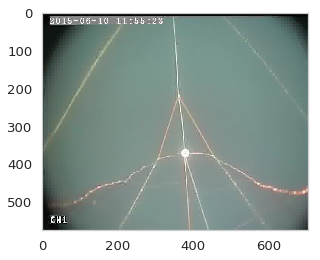

truth: 0.0, prediction: 0, pred_prob: 0.17, filename = /mnt/seals/data/images/test/noseal/s9-5491-00031.jpeg


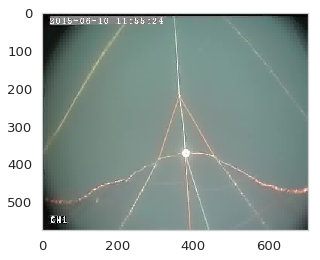

truth: 0.0, prediction: 0, pred_prob: 0.19, filename = /mnt/seals/data/images/test/noseal/s9-5491-00032.jpeg


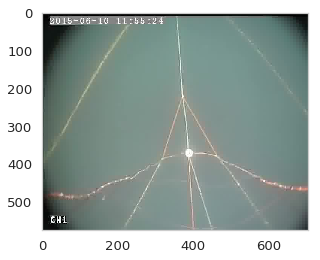

truth: 0.0, prediction: 0, pred_prob: 0.16, filename = /mnt/seals/data/images/test/noseal/s9-5491-00033.jpeg


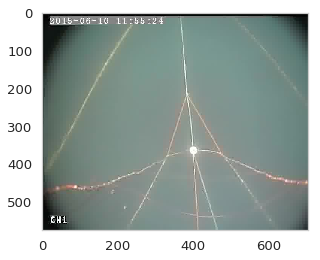

truth: 0.0, prediction: 0, pred_prob: 0.17, filename = /mnt/seals/data/images/test/noseal/s9-5491-00034.jpeg


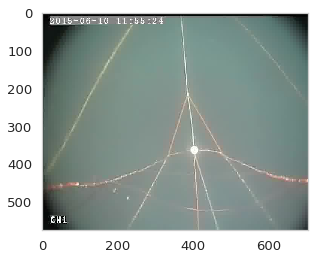

truth: 0.0, prediction: 0, pred_prob: 0.13, filename = /mnt/seals/data/images/test/noseal/s9-5491-00035.jpeg


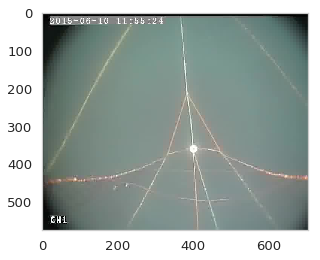

truth: 0.0, prediction: 0, pred_prob: 0.11, filename = /mnt/seals/data/images/test/noseal/s9-5491-00036.jpeg


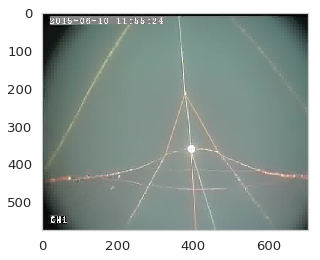

truth: 0.0, prediction: 0, pred_prob: 0.1, filename = /mnt/seals/data/images/test/noseal/s9-5491-00037.jpeg


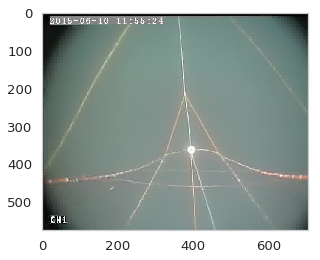

truth: 0.0, prediction: 0, pred_prob: 0.09, filename = /mnt/seals/data/images/test/noseal/s9-5491-00038.jpeg


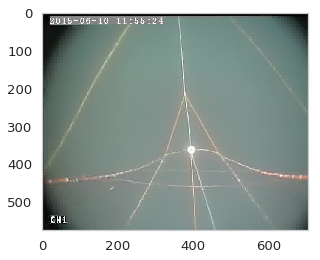

truth: 0.0, prediction: 0, pred_prob: 0.09, filename = /mnt/seals/data/images/test/noseal/s9-5491-00039.jpeg


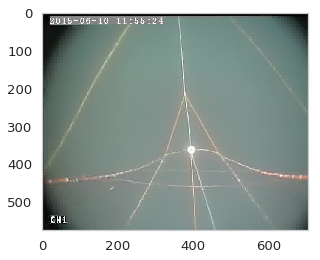

truth: 0.0, prediction: 0, pred_prob: 0.1, filename = /mnt/seals/data/images/test/noseal/s9-5491-00040.jpeg


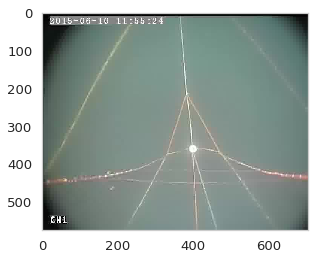

truth: 0.0, prediction: 0, pred_prob: 0.11, filename = /mnt/seals/data/images/test/noseal/s9-5491-00041.jpeg


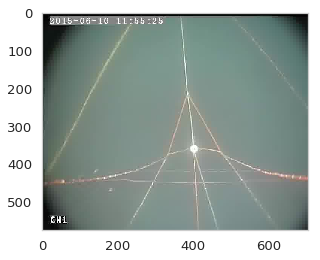

truth: 0.0, prediction: 0, pred_prob: 0.14, filename = /mnt/seals/data/images/test/noseal/s9-5491-00042.jpeg


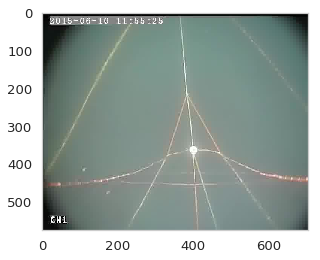

truth: 0.0, prediction: 0, pred_prob: 0.16, filename = /mnt/seals/data/images/test/noseal/s9-5491-00043.jpeg


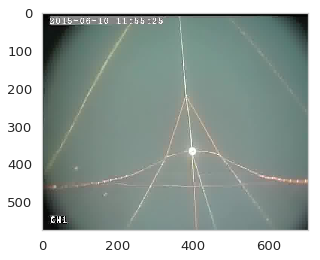

truth: 1.0, prediction: 0, pred_prob: 0.21, filename = /mnt/seals/data/images/test/seal/s9-5491-00044.jpeg


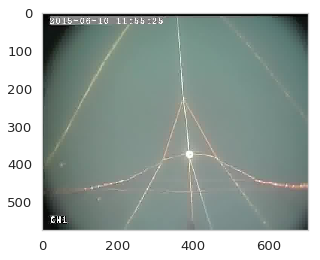

truth: 1.0, prediction: 0, pred_prob: 0.25, filename = /mnt/seals/data/images/test/seal/s9-5491-00045.jpeg


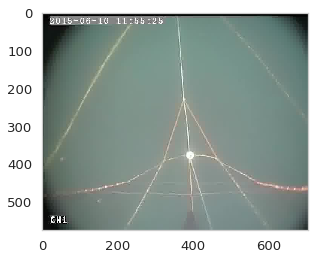

truth: 1.0, prediction: 0, pred_prob: 0.22, filename = /mnt/seals/data/images/test/seal/s9-5491-00046.jpeg


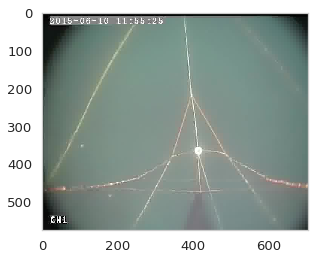

truth: 1.0, prediction: 0, pred_prob: 0.2, filename = /mnt/seals/data/images/test/seal/s9-5491-00047.jpeg


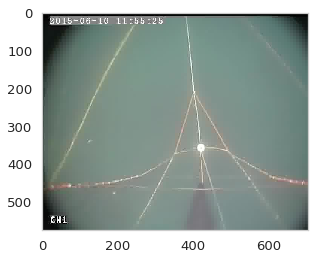

truth: 1.0, prediction: 0, pred_prob: 0.32, filename = /mnt/seals/data/images/test/seal/s9-5491-00048.jpeg


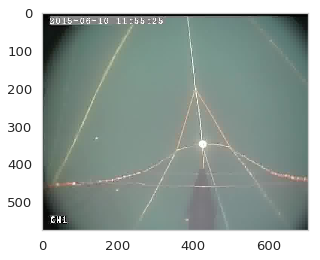

truth: 1.0, prediction: 0, pred_prob: 0.49, filename = /mnt/seals/data/images/test/seal/s9-5491-00049.jpeg


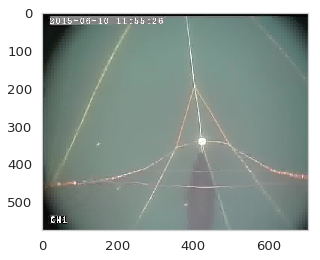

In [216]:
for row in pdf.loc[25:44].values:
    row_dict = dict(zip(pdf.columns,row))
    print("truth: {}, prediction: {}, pred_prob: {}, filename = {}".format(row_dict['truth_seal'], row_dict['prediction'], round(row_dict['seal'],2), row_dict['filename']))
    plot_pic(row_dict['filename'])

In [66]:
x_test.shape

(202, 1536)

In [67]:
predictions = model.predict(x_test)

In [68]:
# calculate test error 
pdf = pd.DataFrame(predictions)
pdf.columns = ['noseal','seal']

# get filenames for predictions
filenames = []
for vid_name in vids_test:
    filenames_vid = list(dfp[dfp['vid'] == vid_name]['path'])
    filenames.extend(filenames_vid[sequence_length-1:])
pdf['filename'] = filenames
print(len(filenames))

truth = pd.DataFrame(y_test)
truth.columns = ['truth_noseal','truth_seal']
truth = truth[['truth_seal']]

pdf['prediction'] = pdf['seal'].apply(lambda x: round(x))

pdf = pd.concat([pdf, truth], axis=1)

pdf['error'] = (pdf['prediction'] != pdf['truth_seal']).astype(int)

202


In [69]:
pdf['error'].mean()

0.12871287128712872

In [70]:
1 - pdf['error'].mean()

0.8712871287128713

In [173]:
pdf.head(100)

,noseal,seal,filename,prediction,truth_seal,error
0,0.95166,0.048338,/mnt/seals/data/images/test/noseal/s9-5491-00001.jpeg,0,0,0
1,0.88197,0.11803,/mnt/seals/data/images/test/noseal/s9-5491-00002.jpeg,0,0,0
2,0.95444,0.04556,/mnt/seals/data/images/test/noseal/s9-5491-00003.jpeg,0,0,0
3,0.97465,0.025348,/mnt/seals/data/images/test/noseal/s9-5491-00004.jpeg,0,0,0
4,0.97465,0.025348,/mnt/seals/data/images/test/noseal/s9-5491-00005.jpeg,0,0,0
5,0.96333,0.036675,/mnt/seals/data/images/test/noseal/s9-5491-00006.jpeg,0,0,0
6,0.94222,0.057782,/mnt/seals/data/images/test/noseal/s9-5491-00007.jpeg,0,0,0
7,0.95119,0.048805,/mnt/seals/data/images/test/noseal/s9-5491-00008.jpeg,0,0,0
8,0.92261,0.07739,/mnt/seals/data/images/test/noseal/s9-5491-00009.jpeg,0,0,0
9,0.93093,0.069073,/mnt/seals/data/images/test/noseal/s9-5491-00010.jpeg,0,0,0


truth: 1.0, prediction: 1, pred_prob: 0.71, filename = /mnt/seals/data/images/test/seal/s9-5491-00078.jpeg


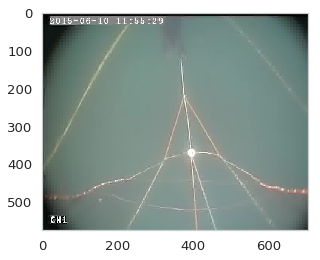

truth: 1.0, prediction: 0, pred_prob: 0.32, filename = /mnt/seals/data/images/test/seal/s9-5491-00079.jpeg


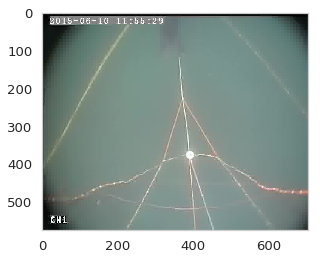

truth: 1.0, prediction: 0, pred_prob: 0.46, filename = /mnt/seals/data/images/test/seal/s9-5491-00080.jpeg


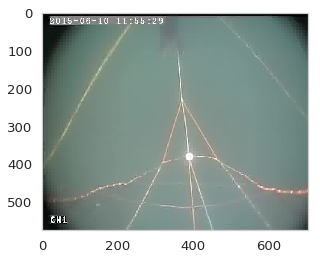

truth: 0.0, prediction: 0, pred_prob: 0.37, filename = /mnt/seals/data/images/test/noseal/s9-5491-00081.jpeg


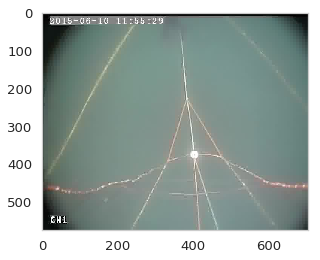

truth: 0.0, prediction: 0, pred_prob: 0.21, filename = /mnt/seals/data/images/test/noseal/s9-5491-00082.jpeg


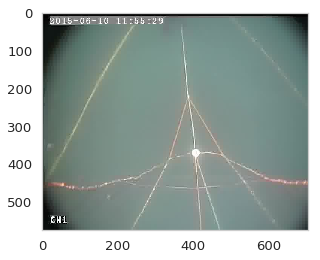

truth: 0.0, prediction: 0, pred_prob: 0.29, filename = /mnt/seals/data/images/test/noseal/s9-5491-00083.jpeg


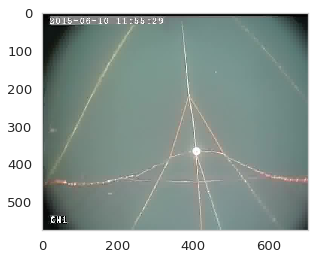

truth: 0.0, prediction: 0, pred_prob: 0.35, filename = /mnt/seals/data/images/test/noseal/s9-5491-00084.jpeg


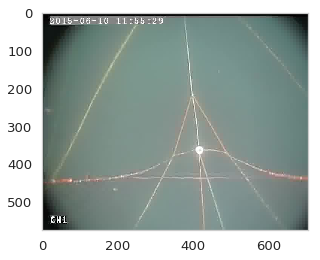

In [151]:
for row in pdf.loc[38:44].values:
    row_dict = dict(zip(pdf.columns,row))
    print("truth: {}, prediction: {}, pred_prob: {}, filename = {}".format(row_dict['truth_seal'], row_dict['prediction'], round(row_dict['seal'],2), row_dict['filename']))
    plot_pic(row_dict['filename'])

In [ ]:
preds = model.predict(x_test)

In [ ]:
preds = pd.DataFrame(preds)
preds.columns = ['noseal','seal']

In [ ]:
truth = pd.DataFrame(y_test)
truth.columns = ['a','truth']
truth = truth[['truth']]

In [ ]:
preds.head()

In [ ]:
preds['label'] = preds['seal'].apply(lambda x: round(x))

In [ ]:
preds = pd.concat([preds, truth], axis=1)

In [ ]:
# preds.head(20)

In [ ]:
# for p in paths[115+10:155+10]:
#     print(p)
#     plot_pic(p)

# notes

> TODO: add learning rate cycling etc

In [ ]:
"""Build a CNN into RNN.
Starting version from:
    https://github.com/udacity/self-driving-car/blob/master/
        steering-models/community-models/chauffeur/models.py

Heavily influenced by VGG-16:
    https://arxiv.org/abs/1409.1556

Also known as an LRCN:
    https://arxiv.org/pdf/1411.4389.pdf
"""
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=self.input_shape))
model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(256, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(512, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(self.nb_classes, activation='softmax'))

return model

In [ ]:
# model = Sequential()

# model.add(LSTM(units=HIDDEN_UNITS, input_shape=(None, num_input_tokens), return_sequences=False, dropout=0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

# # predicting seal or not seal
# model.add(Dense(2))
# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
max_frames = 0
labels = dict()
x_samples, y_samples = features, targets


In [ ]:
frames_list = []
for x in x_samples:
    frames = x.shape[0]
    frames_list.append(frames)
    max_frames = max(frames, max_frames)
    self.expected_frames = int(np.mean(frames_list))
print('max frames: ', max_frames)
print('expected frames: ', self.expected_frames)
for i in range(len(x_samples)):
    x = x_samples[i]
    frames = x.shape[0]
    print(x.shape)
    if frames > self.expected_frames:
        x = x[0:self.expected_frames, :]
        x_samples[i] = x
    elif frames < self.expected_frames:
        temp = np.zeros(shape=(self.expected_frames, x.shape[1]))
        temp[0:frames, :] = x
        x_samples[i] = temp
for y in y_samples:
    if y not in self.labels:
        self.labels[y] = len(self.labels)
print(self.labels)
for i in range(len(y_samples)):
    y_samples[i] = self.labels[y_samples[i]]

self.nb_classes = len(self.labels)

y_samples = np_utils.to_categorical(y_samples, self.nb_classes)

In [ ]:
features[0].shape

In [ ]:
model.summary()

In [ ]:

history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                      epochs=NUM_EPOCHS,
                                      verbose=1, validation_data=test_gen, validation_steps=test_num_batches)

In [ ]:
# def generate_batch(x_samples, y_samples):
#     num_batches = len(x_samples) // BATCH_SIZE

#     while True:
#         for batchIdx in range(0, num_batches):
#             start = batchIdx * BATCH_SIZE
#             end = (batchIdx + 1) * BATCH_SIZE
#             yield np.array(x_samples[start:end]), y_samples[start:end]